## Link Dataset:
https://www.kaggle.com/datasets/prasadvpatil/mrl-dataset

In [ ]:
import kagglehub
import os
import pandas as pd
from sklearn.model_selection import GroupShuffleSplit

DATASET_PATH = kagglehub.dataset_download("prasadvpatil/mrl-dataset/versions/3")
TRAIN_DIR = os.path.join(DATASET_PATH, "train")
print("Path to dataset files:", DATASET_PATH)

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import cv2

BATCH_SIZE = 32
LEARNING_RATE = 1e-4
EPOCHS = 50
IMG_SIZE = 64
VAL_SPLIT = 0.2

device = "cuda" if torch.cuda.is_available() else "cpu"

c:\Users\GN\anaconda3\envs\computer_vision\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: C:\Users\GN\.cache\kagglehub\datasets\prasadvpatil\mrl-dataset\versions\3


In [ ]:
class EyeDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = Image.open(self.image_paths[idx]).convert("L")  
        label = self.labels[idx]

        if self.transform:
            img = self.transform(img)

        return img, label

In [ ]:
classes = sorted(os.listdir(TRAIN_DIR)) 
all_image_paths = []
all_labels = []
all_subject_ids = []

for label_idx, label in enumerate(classes):
    class_dir = os.path.join(TRAIN_DIR, label)
    for img_file in os.listdir(class_dir):
        if img_file.lower().endswith((".png", ".jpg", ".jpeg")):
            full_path = os.path.join(class_dir, img_file)
            all_image_paths.append(full_path)
            all_labels.append(label_idx)
            
            filename = os.path.basename(img_file)
            subject_id = filename.split('_')[0] 
            all_subject_ids.append(subject_id)

df = pd.DataFrame({
    'path': all_image_paths,
    'label': all_labels,
    'subject_id': all_subject_ids
})

splitter = GroupShuffleSplit(test_size=VAL_SPLIT, n_splits=1, random_state=42)
train_idxs, val_idxs = next(splitter.split(df, groups=df['subject_id']))

train_df = df.iloc[train_idxs]
val_df = df.iloc[val_idxs]

train_paths = train_df['path'].tolist()
train_labels = train_df['label'].tolist()
val_paths = val_df['path'].tolist()
val_labels = val_df['label'].tolist()

print(f"Total Subjects: {df['subject_id'].nunique()}")
print(f"Train Subjects: {train_df['subject_id'].nunique()}")
print(f"Val Subjects:   {val_df['subject_id'].nunique()}")
print(f"Train images:   {len(train_paths)}")
print(f"Val images:     {len(val_paths)}")

Total Subjects: 19
Train Subjects: 15
Val Subjects:   4
Train images:   7175
Val images:     2825


In [ ]:
train_subjects = set(train_df['subject_id'])
val_subjects = set(val_df['subject_id'])
overlap = train_subjects.intersection(val_subjects)

print(f"Number of subjects in both Train and Val: {len(overlap)}")

Number of subjects in both Train and Val: 0


In [5]:
train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.4, contrast=0.4),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5]),
])

val_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5]),
])

In [6]:
train_dataset = EyeDataset(train_paths, train_labels, transform=train_transform)
val_dataset   = EyeDataset(val_paths, val_labels, transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [7]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Flatten(),
            nn.Dropout(p=0.5),
            nn.Linear(128 * (IMG_SIZE // 8) * (IMG_SIZE // 8), 128),
            nn.ReLU(),
            nn.Linear(128, 2)
        )

    def forward(self, x):
        return self.net(x)


model = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

Starting Training...


c:\Users\GN\anaconda3\envs\computer_vision\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/50 | Train Loss: 0.3402, Train Acc: 0.8421 | Val Loss: 0.1642, Val Acc: 0.9463
  --> Accuracy Improved (0.0000 -> 0.9463). Saving model...
Epoch 2/50 | Train Loss: 0.1659, Train Acc: 0.9400 | Val Loss: 0.1006, Val Acc: 0.9638
  --> Accuracy Improved (0.9463 -> 0.9638). Saving model...
Epoch 3/50 | Train Loss: 0.0993, Train Acc: 0.9649 | Val Loss: 0.1014, Val Acc: 0.9663
  --> Accuracy Improved (0.9638 -> 0.9663). Saving model...
Epoch 4/50 | Train Loss: 0.0815, Train Acc: 0.9725 | Val Loss: 0.0698, Val Acc: 0.9775
  --> Accuracy Improved (0.9663 -> 0.9775). Saving model...
Epoch 5/50 | Train Loss: 0.0533, Train Acc: 0.9850 | Val Loss: 0.0440, Val Acc: 0.9891
  --> Accuracy Improved (0.9775 -> 0.9891). Saving model...
Epoch 6/50 | Train Loss: 0.0421, Train Acc: 0.9879 | Val Loss: 0.0354, Val Acc: 0.9884
Epoch 7/50 | Train Loss: 0.0301, Train Acc: 0.9899 | Val Loss: 0.0388, Val Acc: 0.9867
Epoch 8/50 | Train Loss: 0.0289, Train Acc: 0.9906 | Val Loss: 0.0183, Val Acc: 0.9940
  --

C:\Users\GN\AppData\Local\Temp\ipykernel_37292\1424709379.py:87: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_eye_model.pth"))


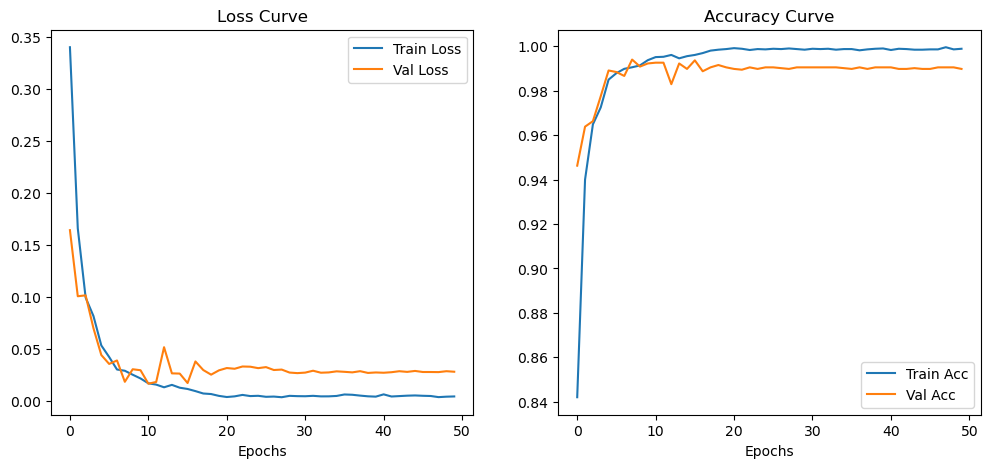

In [ ]:
import torch
import torch.optim as optim
import matplotlib.pyplot as plt

train_losses = []
val_losses = []
train_accs = []
val_accs = []

def accuracy(preds, labels):
    return (preds.argmax(dim=1) == labels).float().mean().item()

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=5, verbose=True
)

best_val_acc = 0.0

early_stopping_patience = 10  
epochs_no_improve = 0

print("Starting Training...")

for epoch in range(EPOCHS):
    model.train()
    total_loss, total_acc = 0, 0

    for imgs, lbls in train_loader:
        imgs, lbls = imgs.to(device), lbls.to(device)

        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, lbls)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_acc += accuracy(outputs, lbls)

    avg_train_loss = total_loss / len(train_loader)
    avg_train_acc = total_acc / len(train_loader)
    
    train_losses.append(avg_train_loss)
    train_accs.append(avg_train_acc)

    model.eval()
    val_loss_sum, val_acc_sum = 0, 0

    with torch.no_grad():
        for imgs, lbls in val_loader:
            imgs, lbls = imgs.to(device), lbls.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, lbls)

            val_loss_sum += loss.item()
            val_acc_sum += accuracy(outputs, lbls)

    avg_val_loss = val_loss_sum / len(val_loader)
    avg_val_acc = val_acc_sum / len(val_loader)

    val_losses.append(avg_val_loss)
    val_accs.append(avg_val_acc)

    scheduler.step(avg_val_loss)

    print(f"Epoch {epoch+1}/{EPOCHS} | "
          f"Train Loss: {avg_train_loss:.4f}, Train Acc: {avg_train_acc:.4f} | "
          f"Val Loss: {avg_val_loss:.4f}, Val Acc: {avg_val_acc:.4f}")

    if avg_val_acc > best_val_acc:
        best_val_acc = avg_val_acc
        torch.save(model.state_dict(), "best_eye_model.pth")
        print(f"  --> Accuracy Improved. Saving model...")
        epochs_no_improve = 0  
    else:
        epochs_no_improve += 1
        print(f"  --> No improvement for {epochs_no_improve}/{early_stopping_patience} epochs.")

    if epochs_no_improve >= early_stopping_patience:
        print("\nEarly Stopping Triggered! Model has stopped improving.")
        print(f"Best Validation Accuracy was: {best_val_acc:.4f}")
        break

print(f"\nTraining Complete. Best Validation Accuracy: {best_val_acc:.4f}")
print("Loading best model weights...")
model.load_state_dict(torch.load("best_eye_model.pth"))

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.title("Loss Curve")
plt.xlabel("Epochs")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accs, label="Train Acc")
plt.plot(val_accs, label="Val Acc")
plt.title("Accuracy Curve")
plt.xlabel("Epochs")
plt.legend()

plt.show()

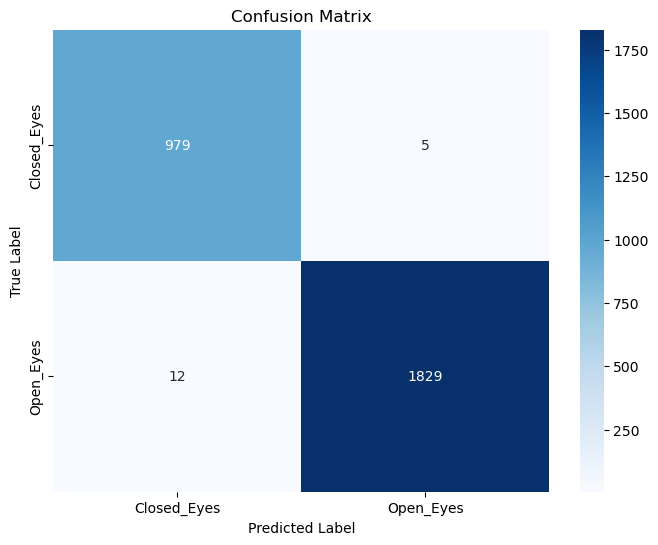

Classification Report:
               precision    recall  f1-score   support

 Closed_Eyes       0.99      0.99      0.99       984
   Open_Eyes       1.00      0.99      1.00      1841

    accuracy                           0.99      2825
   macro avg       0.99      0.99      0.99      2825
weighted avg       0.99      0.99      0.99      2825



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import seaborn as sns

model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for imgs, lbls in val_loader:
        imgs, lbls = imgs.to(device), lbls.to(device)
        outputs = model(imgs)
        _, predicted = torch.max(outputs.data, 1)
        y_true.extend(lbls.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

y_true = np.array(y_true)
y_pred = np.array(y_pred)

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

report = classification_report(y_true, y_pred, target_names=classes)
print("Classification Report:\n", report)

In [10]:
torch.save(model.state_dict(), "eye_classifier.pth")